In [1]:
using Pkg 
Pkg.activate(".")

  Activating project at `~/PhD/GaussianProcessNode`


In [2]:
using Revise 
using StableRNGs, GraphPPL,ReactiveMP, RxInfer, Random, Distributions, LinearAlgebra, Plots
using Flux, Zygote, ForwardDiff
using SpecialFunctions, Optim,ExponentialAction
using BenchmarkTools
import KernelFunctions: SqExponentialKernel, Matern52Kernel, with_lengthscale, Kernel, kernelmatrix  
import ReactiveMP: GaussHermiteCubature, approximate_meancov, InverseWishartMessage

In [3]:
function generate_data(n,f_gp, σ_x, σ_y)
    obs = []
    for i=1:n
        x_t = σ_x * randn() 
        temp = x_t * exp(f_gp[i])    
        push!(obs, temp)
    end
    return obs
end

generate_data (generic function with 1 method)

In [25]:
Random.seed!(1)

σ_c = 2pi/30 # true frequency
σ_y = 0.001 ## we assume low noise for now

N = 400; #data length
n = 400; #length of the axis of gp 

## GP information
meanf = (x) -> 0.0;
kernel(θ) = with_lengthscale(Matern52Kernel(),θ)
tmin,tmax = 0., 4.0
time_range = collect(range(tmin, tmax; length=n));

θ_gp = 1. #true θ_gp

Cov_mat = kernelmatrix(kernel(θ_gp),time_range,time_range) + 1e-8*I;
gp = MvNormal(meanf.(time_range), Cov_mat)
f_test = rand(gp)

#Observe data 
pos = sort(randperm(n)[1:N]); # position where we observe data
time_train = time_range[pos]
f_train = f_test[pos];
slicedim(dim) = (a) -> map(e -> e[dim], a);

In [5]:
#Generate data 
y_data = generate_data(N,f_train,σ_c,σ_y);

In [6]:
#Exponentiate function 
struct MyExponential end

@node MyExponential Deterministic [ y, x ]   ## x: input,  y: output


@rule MyExponential(:y, Marginalisation) (m_x::UnivariateGaussianDistributionsFamily,) = begin 
    return LogNormal(mean(m_x), var(m_x))
end

@rule MyExponential(:x, Marginalisation) (m_y::ContinuousUnivariateLogPdf, m_x::UnivariateGaussianDistributionsFamily, ) = begin 
    dist = m_x    
    m_in, var_in = mean_var(m_x)
    l_pdf = (x) -> logpdf(m_y,exp.(x)) 
    pdf = x -> exp(l_pdf(x)-logpdf(dist,x)+1e-7)
    m,v = approximate_meancov(ghcubature(131),pdf,dist)

    if isnan(v) || isnan(m)
        log_pdf = x -> l_pdf(x) + logpdf(dist,x[1])  + 1e-7
        res = optimize(x -> -log_pdf(x), [m_in])
        mproxy = res.minimizer[1]
        dx  = x -> ForwardDiff.derivative(y -> -log_pdf(y),x)
        ddx = x -> ForwardDiff.derivative(dx, x)

        vproxy = cholinv(ddx(mproxy+tiny))
        m_ = mproxy 
        v_ = vproxy + 1e-6

        ksi = m_/v_ - m_in/var_in
        precision = clamp(1/v_ - 1/var_in, tiny,huge)

        if isnan(ksi) || isnan(precision)
            samples = rand(dist,2000)
            weights = exp.(l_pdf.(samples)) / sum(exp.(l_pdf.(samples)) )
            if any(isnan.(weights)) 
                m_ = sum(samples)/2000
                v_ = sum((samples .- m_).^2) /2000 
            else
                m_ = sum(weights .* samples)
                v_ = sum(weights .* (samples .- m_).^2)    
            end
            ksi = m_/v_ - m_in/var_in
            precision = clamp(1/v_ - 1/var_in, tiny,huge)
            
            return NormalWeightedMeanPrecision(ksi,precision)
        else
            return  NormalWeightedMeanPrecision(ksi,precision)
        end
    else
        return  NormalMeanVariance(m,v)
    end
end

In [7]:
#use Gaussian GaussHermiteCubature to approximate 
#Temporarily put here 
function ReactiveMP.prod(::ProdAnalytical, left::UnivariateGaussianDistributionsFamily, right::ContinuousUnivariateLogPdf) 
    #we use Gaussian Hermite Cubature here, not ProdAnalytical 
#     meta = GaussHermiteCubature(121)
#     m,v = ReactiveMP.approximate_meancov(meta, z -> exp(right.logpdf(z)), mean(left), var(left))
#     return NormalMeanVariance(m,v)
    sample_left = rand(left,500)
    f_samples_evaluated = [exp(logpdf(right,sample_left[i])) for i=1:length(sample_left)]
    p_samples_evaluated = [pdf(left,sample_left[i]) for i=1:length(sample_left)]
    m = sum(sample_left .* p_samples_evaluated .* f_samples_evaluated)
    @show v = sum((sample_left .- m).^2 .* p_samples_evaluated .* f_samples_evaluated)
    if isnan(v)
        k = sample_left .* p_samples_evaluated .* f_samples_evaluated
        for i =1:length(k) 
            if isnan(k[i])
                sample_left[i] = 1e-2
            end
        end
        f_samples_evaluated = [exp(logpdf(right,sample_left[i])) for i=1:length(sample_left)]
        p_samples_evaluated = [pdf(left,sample_left[i]) for i=1:length(sample_left)]
        m = sum(sample_left .* p_samples_evaluated .* f_samples_evaluated)
        v = sum((sample_left .- m).^2 .* p_samples_evaluated .* f_samples_evaluated) + 1e-6
    end
    @show m,v
    return NormalMeanVariance(m,v)
end

function ReactiveMP.prod(::ProdAnalytical, left::ContinuousUnivariateLogPdf, right::UnivariateGaussianDistributionsFamily)
#     meta = GaussHermiteCubature(121)
#     m,v = ReactiveMP.approximate_meancov(meta, z -> exp(left.logpdf(z)), mean(right), var(right))
    sample_right = rand(right,500)
    f_samples_evaluated = [exp(logpdf(left,sample_right[i])) for i=1:length(sample_right)]
    p_samples_evaluated = [pdf(right,sample_right[i]) for i=1:length(sample_right)]
    m = sum(sample_right .* p_samples_evaluated .* f_samples_evaluated)
    v = sum((sample_right .- m).^2 .* p_samples_evaluated .* f_samples_evaluated)
    if isnan(v)
        k = sample_right .* p_samples_evaluated .* f_samples_evaluated
        for i =1:length(k) 
            if isnan(k[i])
                sample_right[i] = 1e-2
            end
        end
        f_samples_evaluated = [exp(logpdf(left,sample_right[i])) for i=1:length(sample_right)]
        p_samples_evaluated = [pdf(right,sample_right[i]) for i=1:length(sample_right)]
        m = sum(sample_right .* p_samples_evaluated .* f_samples_evaluated)
        v = sum((sample_right .- m).^2 .* p_samples_evaluated .* f_samples_evaluated) +1e-6
    end
    @show m,v
    return NormalMeanVariance(m,v)
end

function ReactiveMP.prod(::ProdAnalytical, left::LogNormal, right::ContinuousUnivariateLogPdf) 
    sample_left = rand(left,500)
    f_samples_evaluated = [exp(logpdf(right,sample_left[i])) for i=1:length(sample_left)]
    p_samples_evaluated = [pdf(left,sample_left[i]) for i=1:length(sample_left)]
    m = sum(sample_left .* p_samples_evaluated .* f_samples_evaluated)
    v = sum((sample_left .- m).^2 .* p_samples_evaluated .* f_samples_evaluated)
    if isnan(v)
        k = sample_left .* p_samples_evaluated .* f_samples_evaluated
        for i =1:length(k) 
            if isnan(k[i])
                sample_left[i] = 1e-2
            end
        end
        f_samples_evaluated = [exp(logpdf(right,sample_left[i])) for i=1:length(sample_left)]
        p_samples_evaluated = [pdf(left,sample_left[i]) for i=1:length(sample_left)]
        m = sum(sample_left .* p_samples_evaluated .* f_samples_evaluated)
        v = sum((sample_left .- m).^2 .* p_samples_evaluated .* f_samples_evaluated)
    end
    return LogNormal(m,v)
end

In [8]:
@rule typeof(*)(:A, Marginalisation) (m_out::UnivariateGaussianDistributionsFamily, m_A::UnivariateGaussianDistributionsFamily, m_in::LogNormal, meta::TinyCorrection) = begin 
    #mean_in and var_in come from m_A
    backward_A = @call_rule typeof(*)(:A, Marginalisation) (m_out = m_out, m_in = m_in, meta=meta)
    mean_in, var_in = mean_var(m_A)
    dist = m_A 
    pdf = x -> exp(backward_A(x)-logpdf(dist,x)+1e-7)
    m,v = approximate_meancov(ghcubature(121),pdf,dist)

    if isnan(v) || isnan(m)
        log_pdf = x -> backward_A(x) + logpdf(dist,x[1])  + 1e-7
        res = optimize(x -> -log_pdf(x), [mean_in])
        mproxy = res.minimizer[1]
        dx  = x -> ForwardDiff.derivative(y -> -log_pdf(y),x)
        ddx = x -> ForwardDiff.derivative(dx, x)

        vproxy = cholinv(ddx(mproxy+tiny))
        m_ = mproxy 
        v_ = vproxy + 1e-6

        ksi = m_/v_ - mean_in/var_in
        precision = clamp(1/v_ - 1/var_in, tiny,huge)

        if isnan(ksi) || isnan(precision)
            samples = rand(dist,3000)
            weights = exp.(backward_A.(samples)) / sum(exp.(backward_A.(samples)) )
            if any(isnan.(weights)) 
                m_ = sum(samples)/3000
                v_ = sum((samples .- m_).^2) /3000
            else
                m_ = sum(weights .* samples)
                v_ = sum(weights .* (samples .- m_).^2)    
            end
            ksi = m_/v_ - mean_in/var_in
            precision = clamp(1/v_ - 1/var_in, tiny,huge)
            
            return NormalWeightedMeanPrecision(ksi,precision)
        else
            return  NormalWeightedMeanPrecision(ksi,precision)
        end
    else
        return  NormalMeanVariance(m,v)
    end
end

@rule typeof(*)(:A, Marginalisation) (m_out::PointMass, m_A::UnivariateGaussianDistributionsFamily, m_in::LogNormal, meta::TinyCorrection) = begin 
    backward_A = (x) -> -log(abs(x)) + logpdf(m_in,mean(m_out)/x)
    mean_in, var_in = mean_var(m_A)
    dist = m_A 
    pdf = x -> exp(backward_A(x)-logpdf(dist,x)+1e-7)
    m,v = approximate_meancov(ghcubature(121),pdf,dist)

    if isnan(v) || isnan(m)
        log_pdf = x -> backward_A(x[1]) + logpdf(dist,x[1])  + 1e-7
        res = optimize(x -> -log_pdf(x), [mean_in])
        mproxy = res.minimizer[1]
        dx  = x -> ForwardDiff.derivative(y -> -log_pdf(y),x)
        ddx = x -> ForwardDiff.derivative(dx, x)

        vproxy = cholinv(ddx(mproxy+tiny))
        m_ = mproxy 
        v_ = vproxy + 1e-6

        ksi = m_/v_ - mean_in/var_in
        precision = clamp(1/v_ - 1/var_in, tiny,huge)

        if isnan(ksi) || isnan(precision)
            samples = rand(dist,3000)
            weights = exp.(backward_A.(samples)) / sum(exp.(backward_A.(samples)) )
            if any(isnan.(weights)) 
                m_ = sum(samples)/3000
                v_ = sum((samples .- m_).^2) /3000
            else
                m_ = sum(weights .* samples)
                v_ = sum(weights .* (samples .- m_).^2)    
            end
            ksi = m_/v_ - mean_in/var_in
            precision = clamp(1/v_ - 1/var_in, tiny,huge)
            
            return NormalWeightedMeanPrecision(ksi,precision)
        else
            return  NormalWeightedMeanPrecision(ksi,precision)
        end
    else
        return  NormalMeanVariance(m,v)
    end
end

@rule typeof(*)(:A, Marginalisation) (m_out::PointMass, m_in::UnivariateGaussianDistributionsFamily, meta::TinyCorrection) = begin 
    backward_A = (x) -> -log(abs(x)) + logpdf(m_in,mean(m_out)/x)
    return ContinuousUnivariateLogPdf(backward_A)
end

In [9]:
#node ComputeMatP
struct ComputeMatP end

@node ComputeMatP Deterministic [ P, λ ]   ## λ: input (already in log-scale),  P: output

@rule ComputeMatP(:P, Marginalisation) (m_λ::UnivariateGaussianDistributionsFamily, ) = begin 
    λ = mean(m_λ)
    P  = compute_P∞(λ)
    P_vec = vec(P)
    d = length(P)
    return MvNormalMeanCovariance(P_vec, 0.1*diageye(d))
end

@rule ComputeMatP(:λ, Marginalisation) (m_P::MultivariateGaussianDistributionsFamily, ) = begin 
    Pvec = (x) -> vec(compute_P∞(x))
    backwardpass = (x) -> logpdf(m_P, Pvec(x))
    return ContinuousUnivariateLogPdf(backwardpass)
end

@rule ComputeMatP(:λ, Marginalisation) (m_P::MultivariateGaussianDistributionsFamily, m_λ::UnivariateGaussianDistributionsFamily, ) = begin 
    Pvec = (x) -> vec(compute_P∞(x))
    backward_λ = (x) -> logpdf(m_P, Pvec(x))
    mean_in, var_in = mean_var(m_λ)
    dist = m_λ

    samples = rand(dist,3000)
    weights = exp.(backward_λ.(samples)) / sum(exp.(backward_λ.(samples)) )
    if any(isnan.(weights)) 
        m_ = sum(samples)/3000
        v_ = sum((samples .- m_).^2) /3000
    else
        m_ = sum(weights .* samples)
        v_ = sum(weights .* (samples .- m_).^2)    
    end
    ksi = m_/v_ - mean_in/var_in
    precision = clamp(1/v_ - 1/var_in, tiny,huge)

    return NormalWeightedMeanPrecision(ksi,precision)
end
    
#node ComputeMatA
struct ComputeMatA end 

@node ComputeMatA Deterministic [ A, λ ]   ## λ: input,  A: output

@rule ComputeMatA(:A, Marginalisation) (m_λ::UnivariateGaussianDistributionsFamily, ) = begin 
    λ = mean(m_λ)
    
    A = compute_A(λ)
    A_vec = vec(A)
    d = length(A)
    return MvNormalMeanCovariance(A_vec, 0.1*diageye(d))
end

@rule ComputeMatA(:λ, Marginalisation) (m_A::MultivariateGaussianDistributionsFamily, ) = begin 
    Avec = (x) -> vec(compute_A(x))
    backwardpass = (x) -> logpdf(m_A, Avec(x))
    return ContinuousUnivariateLogPdf(backwardpass)
end
        
        
@rule ComputeMatA(:λ, Marginalisation) (m_A::MultivariateGaussianDistributionsFamily, m_λ::UnivariateGaussianDistributionsFamily, ) = begin 
    Avec = (x) -> vec(compute_A(x))
    backward_λ = (x) -> logpdf(m_A, Avec(x))
    mean_in, var_in = mean_var(m_λ)
    dist = m_λ
            
    samples = rand(dist,3000)
    weights = exp.(backward_λ.(samples)) / sum(exp.(backward_λ.(samples)) )
    if any(isnan.(weights)) 
        m_ = sum(samples)/3000
        v_ = sum((samples .- m_).^2) /3000
    else
        m_ = sum(weights .* samples)
        v_ = sum(weights .* (samples .- m_).^2)    
    end
    ksi = m_/v_ - mean_in/var_in
    precision = clamp(1/v_ - 1/var_in, tiny,huge)
            
    return NormalWeightedMeanPrecision(ksi,precision)
end

#node ComputeMatQ
struct ComputeMatQ end 

@node ComputeMatQ Deterministic [ Q, λ ]   ## λ: input,  Q: output

@rule ComputeMatQ(:Q, Marginalisation) (m_λ::UnivariateGaussianDistributionsFamily, ) = begin 
    λ  = mean(m_λ)
    Q  = compute_Q(λ)
    Q_vec = vec(Q)
    d = length(Q)
    return MvNormalMeanCovariance(Q_vec, 0.1*diageye(d))
end

@rule ComputeMatQ(:λ, Marginalisation) (m_Q::MultivariateGaussianDistributionsFamily, ) = begin 
    Qvec = (x) -> vec(compute_Q(x))
    backwardpass = (x) -> logpdf(m_Q, Qvec(x))
    return ContinuousUnivariateLogPdf(backwardpass)
end
            
            
@rule ComputeMatQ(:λ, Marginalisation) (m_Q::MultivariateGaussianDistributionsFamily, m_λ::UnivariateGaussianDistributionsFamily, ) = begin 
    Qvec = (x) -> vec(compute_Q(x))
    backward_λ = (x) -> logpdf(m_Q, Qvec(x))
    mean_in, var_in = mean_var(m_λ)
    dist = m_λ
                
    samples = rand(dist,3000)
    weights = exp.(backward_λ.(samples)) / sum(exp.(backward_λ.(samples)) )
    if any(isnan.(weights)) 
        m_ = sum(samples)/3000
        v_ = sum((samples .- m_).^2) /3000
    else
        m_ = sum(weights .* samples)
        v_ = sum(weights .* (samples .- m_).^2)    
    end
    ksi = m_/v_ - mean_in/var_in
    precision = clamp(1/v_ - 1/var_in, tiny,huge)

    return  NormalWeightedMeanPrecision(ksi,precision)
end

In [10]:
struct ReShape end 
@node ReShape Deterministic [matrix, vector]  # this node transforms a vector to matrix and vice versa

@rule ReShape(:matrix, Marginalisation) (m_vector::MultivariateGaussianDistributionsFamily, ) = begin 
    mean_vector = mean(m_vector)
    d = length(mean_vector)
    n = Int(sqrt(d))
    M = reshape(mean_vector,n,n)
    return Tuple([M])
end

@rule ReShape(:vector, Marginalisation) (m_matrix::Tuple, ) = begin 
    matrix = m_matrix[1]
    vector = vec(matrix)
    d = length(matrix)
    return MvNormalMeanCovariance(vector, 0.1*diageye(d))
end


In [72]:
@rule MvNormalMeanCovariance(:out, Marginalisation) (m_μ::MultivariateGaussianDistributionsFamily, m_Σ::Tuple, ) = begin 
    μ_mean, μ_cov = mean_cov(m_μ)
    Σ = m_Σ[1]
    return MvNormalMeanCovariance(μ_mean, μ_cov + Σ)
#     return MvNormalMeanCovariance(μ_mean, Σ) #VMP rule
end

@rule MvNormalMeanCovariance(:out, Marginalisation) (m_μ::PointMass, m_Σ::Tuple, ) = begin 
    Σ = m_Σ[1]
    return MvNormalMeanCovariance(mean(m_μ), Σ)
end

@rule MvNormalMeanCovariance(:Σ, Marginalisation) (m_out::MultivariateGaussianDistributionsFamily, m_μ::MultivariateGaussianDistributionsFamily, ) = begin
    m_mean, v_mean = mean_cov(m_μ)
    m_out, v_out = mean_cov(m_out)
    S  = v_mean + v_out + (m_mean - m_out) * (m_mean - m_out)'
    return Tuple([S])
end

@rule MvNormalMeanCovariance(:out, Marginalisation) (m_Σ::Tuple, q_μ::PointMass, ) = begin 
    Σ = m_Σ[1]
    return MvNormalMeanCovariance(mean(q_μ), Σ)
end

@rule MvNormalMeanCovariance(:Σ, Marginalisation) (m_out::MultivariateGaussianDistributionsFamily, q_μ::PointMass, ) = begin 
    m_mean = mean(q_μ)
    m_out, v_out = mean_cov(m_out)
    S  = v_out + (m_mean - m_out) * (m_mean - m_out)'
    return Tuple([S])
end

@rule MvNormalMeanCovariance(:μ, Marginalisation) (m_out::MultivariateGaussianDistributionsFamily, m_Σ::Tuple, ) = begin 
    m_out_mean, m_out_cov = mean_cov(m_out)
    Σ = m_Σ[1]
    return MvNormalMeanCovariance(m_out_mean, m_out_cov + Σ)
#     return MvNormalMeanCovariance(m_out_mean, Σ) # VMP rule 
end

### additional rules for multiplication
@rule typeof(*)(:A, Marginalisation) (m_out::MultivariateGaussianDistributionsFamily, m_in::MultivariateGaussianDistributionsFamily, meta::TinyCorrection) = begin
    ybar, invW = mean_cov(m_out)
    xbar, Σx = mean_cov(m_in)

    A = ybar * xbar' * inv(Σx + xbar*xbar')
    return Tuple([A])
end

@rule typeof(*)(:in, Marginalisation) (m_out::MultivariateGaussianDistributionsFamily, m_A::Tuple, meta::TinyCorrection) = begin
    A = m_A[1]
    μ_out, Σ_out = mean_cov(m_out)

    z = ReactiveMP.fastcholesky(Σ_out)
    tmp = A' / z
    W = ReactiveMP.correction!(meta, tmp * A)

    return MvNormalWeightedMeanPrecision(tmp * μ_out, W)
end

@rule typeof(*)(:A, Marginalisation) (m_out::MultivariateGaussianDistributionsFamily, m_in::Tuple, meta::TinyCorrection) = begin
    A = m_in[1]
    μ_out, Σ_out = mean_cov(m_out)

    z = ReactiveMP.fastcholesky(Σ_out)
    tmp = A' / z
    W = ReactiveMP.correction!(meta, tmp * A)

    return MvNormalWeightedMeanPrecision(tmp * μ_out, W)
end

@rule typeof(*)(:in, Marginalisation) (m_out::MultivariateGaussianDistributionsFamily, m_A::MultivariateGaussianDistributionsFamily, meta::TinyCorrection) = begin
    return @call_rule typeof(*)(:A, Marginalisation) (m_out = m_out, m_in=m_A, meta=meta)
end

@rule typeof(*)(:out, Marginalisation) (m_A::Tuple, m_in::MultivariateGaussianDistributionsFamily, meta::TinyCorrection) = begin
    A = m_A[1]
    μ_in, Σ_in = mean_cov(m_in)
    return MvNormalMeanCovariance(A * μ_in, A * Σ_in * A')
end

In [93]:
@model function gpPAD_params(n, l_λ_init,H)
    y = datavar(Float64,n)
    f = randomvar(n)
    z = randomvar(n)
    g = randomvar(n)
    c = randomvar(n)
    w = randomvar(n)
    B = randomvar(n)
    A = randomvar(n)
    Avec = randomvar(n)
    Qvec = randomvar(n)
    Q = randomvar(n)
    
    l_λ ~ NormalMeanVariance(l_λ_init, 10.)
    P∞_vec ~ ComputeMatP(l_λ) where {pipeline = RequireMessage(λ = NormalMeanVariance(l_λ_init, 10.))}
    P∞ ~ ReShape(P∞_vec)
    f_0 ~ MvNormalMeanCovariance(zeros(length(H)), P∞)
    
    f_prev = f_0
    for i=1:n 
        Avec[i] ~ ComputeMatA(l_λ) where {pipeline = RequireMessage(λ = NormalMeanVariance(l_λ_init, 10.))}
        A[i] ~ ReShape(Avec[i])
        Qvec[i] ~ ComputeMatQ(l_λ) where {pipeline = RequireMessage(λ = NormalMeanVariance(l_λ_init, 10.))}
        Q[i] ~ ReShape(Qvec[i])
        B[i] ~ (*)(A[i],f_prev) where {meta = TinyCorrection()}
        f[i] ~ MvNormalMeanCovariance(B[i], Q[i])
        z[i] ~ NormalMeanVariance(dot(H , f[i]), 0.01)

        g[i] ~ MyExponential(z[i]) where {pipeline = RequireMessage(x = NormalMeanPrecision(0., 0.01))}
        c[i] ~ NormalMeanPrecision(0.0,1/(σ_c)^2) 
        w[i] ~ (*)(c[i],g[i]) where {meta = TinyCorrection()}
        y[i] ~ NormalMeanPrecision(w[i], 1/σ_y^2)
        f_prev = f[i]
    end
end

In [94]:
function compute_F(logλ)
    F = [0. 1. 0.; 0. 0. 1.;-exp(logλ[])^3 -3exp(logλ[])^2 -3exp(logλ[])]
    return F 
end

function compute_A(logλ)
    F = [0. 1. 0.; 0. 0. 1.;-exp(logλ[])^3 -3exp(logλ[])^2 -3exp(logλ[])]
    Imat = diageye(3)
    A = expv(Δt,F,Imat)
    return A 
end

function compute_P∞(logλ)
    F = [0. 1. 0.; 0. 0. 1.;-exp(logλ[])^3 -3exp(logλ[])^2 -3exp(logλ[])]
    Imat = diageye(3)
    Qc = 16/3 * exp(logλ[])^5
    L = [0., 0., 1.];
    vec_P = inv(kron(Imat,F) + kron(F,Imat)+ 1e-8*diageye(9)) * vec(-L * Qc * L')
    P∞ = reshape(vec_P,3,3)
    return P∞
end

function compute_Q(logλ)
    F = [0. 1. 0.; 0. 0. 1.;-exp(logλ[])^3 -3exp(logλ[])^2 -3exp.(logλ[])]
    Imat = diageye(3)
    A = expv(Δt,F,Imat)
    Qc = 16/3 * exp(logλ[])^5
    L = [0., 0., 1.];
    vec_P = inv(kron(Imat,F) + kron(F,Imat)+ 1e-8*diageye(9)) * vec(-L * Qc * L')
    P∞ = reshape(vec_P,3,3)
    Q = P∞ - A*P∞*A'
    return Q 
end

compute_Q (generic function with 1 method)

In [95]:
Δt = time_range[2] - time_range[1]; # time difference

l_init = 1.;
λ_init = sqrt(5)/l_init;
logλ_init = log(λ_init);

L = [0., 0., 1.];
H = [1., 0., 0.];
F_init = [0. 1. 0.; 0. 0. 1.;-λ_init^3 -3λ_init^2 -3λ_init]
Qc = 16/3 * λ_init^5;

Imat = diageye(3) ; 
vec_P = inv(kron(Imat,F_init) + kron(F_init,Imat)) * vec(-L * Qc * L'); 
P∞_init = reshape(vec_P,3,3);
A_init = exp(F_init * Δt)
Q = P∞_init - A_init * P∞_init * A_init';

In [96]:
function Distributions.logkernel(d::InverseWishartMessage, X::AbstractMatrix)
    p = size(d, 1)
    df = d.ν

    Xcf = ReactiveMP.fastcholesky(X + 1e-6*ones(p,p))
    # we use the fact: tr(Ψ * inv(X)) = tr(inv(X) * Ψ) = tr(X \ Ψ)
    Ψ = Matrix(d.S)
    -0.5 * ((df + p + 1) * logdet(Xcf) + tr(Xcf \ Ψ))
end

function Distributions.logkernel(d::InverseWishart, X::AbstractMatrix)
    p = size(d, 1)
    df = d.df

    Xcf = ReactiveMP.fastcholesky(X + 1e-6*ones(p,p))
    # we use the fact: tr(Ψ * inv(X)) = tr(inv(X) * Ψ) = tr(X \ Ψ)
    Ψ = Matrix(d.Ψ)
    -0.5 * ((df + p + 1) * logdet(Xcf) + tr(Xcf \ Ψ))
end

function Distributions.invwishart_logc0(df::Real, Ψ::AbstractMatrix)
    h_df = -df / 2
    p = size(Ψ, 1)
    -h_df * (p * typeof(df)(log(2)) - logdet(Ψ)) - Distributions.logmvgamma(p, h_df)
end

Distributions._logpdf(d::InverseWishartMessage, X::AbstractMatrix{<:Real}) = Distributions.logkernel(d, X) + Distributions.invwishart_logc0(d.ν, d.S)

In [97]:
function ReactiveMP.prod(::ProdAnalytical, left::Tuple{Matrix{Float64}}, right::Tuple{Matrix{Float64}})
    left_matrix = left[1]
    right_matrix = right[1]
    return Tuple([left_matrix .* right_matrix])
#     return right
end

In [ ]:
nits =1

iresult = inference(
    model = gpPAD_params(length(y_data),logλ_init,H),
    iterations = nits, 
    data  = (y = y_data,),
    initmessages = (l_λ = NormalMeanVariance(logλ_init, 10.),),
    returnvars = (l_λ = KeepLast(),f = KeepLast(),),
    options = (limit_stack_depth=500,),
    # constraints = gp_PAD_constraints(),
    showprogress = true
)

In [88]:
log_λ =  mean(iresult.posteriors[:l_λ])
λ = exp(log_λ)
l = sqrt(5) / λ

2.2362391657769325

In [89]:
mgp = mean.(iresult.posteriors[:f]) |> slicedim(1)
vgp = var.(iresult.posteriors[:f]) |> slicedim(1)
expvgp = exp.( mgp .+ vgp)
expmgp = exp.(mgp);

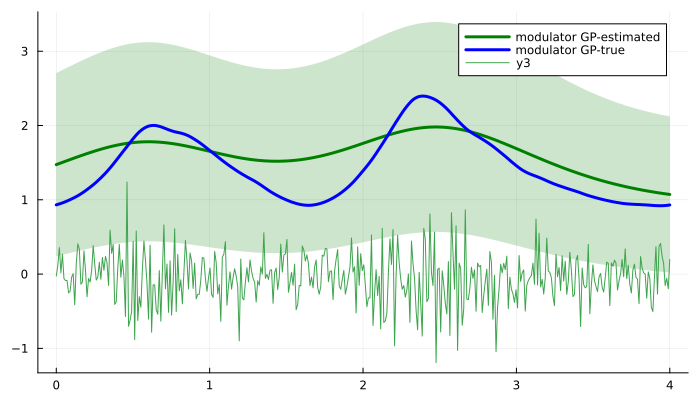

In [90]:
plot(time_range,expmgp,ribbon=sqrt.(expvgp),linewidth=3.0,label="modulator GP-estimated",fillalpha=0.2,color=:green, size = (700, 400))
plot!(time_range,exp.(f_test), label="modulator GP-true",linewidth=3.0,color=:blue)
plot!(time_range, y_data)